In [1]:
import axs
import numpy as np

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as sparkfunc
import pyspark.sql.types as pyspark_types
import numpy as np

from functools import partial

import tqdm

In [2]:
%matplotlib notebook

# Setup spark

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            #.config("spark.master", "local[32]") # yolo mode
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/users/kyboone/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

Hovering over "Spark UI" above gives you the port number of the Spark web dashboard.  Epyc doesn't have that port open, though, so we use an SSH tunnel to forward the ports.  I like to put the following function into my `.bashrc` o my local machine:


```
function spark_tunnel()
{
        # this function takes one argument: the epyc port to tunnel
        # the ordering is backwards (requiring a manual refresh) because
        # I want to be able to manually kill the ssh tunnel
        open http://localhost:${1}/
        ssh -N -L ${1}:127.0.0.1:${1} username@epyc.astro.washington.edu
}
```

What tables does AXS know about?

In [5]:
#catalog.list_table_names()

# Load ZTF data

In [6]:
ztf = catalog.load('ztf_oct19')

# Plotting

In [7]:
band_colors = {
    'g': 'tab:green',
    'r': 'tab:red',
    'i': 'tab:purple'
    
}

def plot_lightcurve(row):
    plt.figure(figsize=(8, 6))

    for band in ['g', 'r', 'i']:
        mask = (
            (np.array(row[f'catflags_{band}']) == 0.)
        )
        def cc(x):
            return np.array(x)[mask]
        plt.errorbar(cc(row[f'mjd_{band}']), cc(row[f'mag_{band}']), cc(row[f'magerr_{band}']),
                     fmt='o', c=band_colors[band], label=f'ZTF-{band}')

    plt.xlabel('MJD')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.title('objid %d' % row['objid'])
    plt.gca().invert_yaxis()

# Cython setup

In [8]:
def setup_pyximport():
    import pyximport
    pyximport.install(reload_support=True, setup_args={'include_dirs': np.get_include()})

class cython_function():
    def __init__(self, module, name):
        self.module = module
        self.name = name
        self.function = None
        
        self.load_function()
        
    def load_function(self):
        setup_pyximport()
        self.function = getattr(__import__(self.module), self.name)
        
    def __call__(self, *args, **kwargs):
        if self.function is None:
            self.load_function()

        return self.function(*args, **kwargs)
    
    def __getstate__(self):
        # Don't return the module so that each node has to recompile it itself.
        state = self.__dict__.copy()
        state['function'] = None
        return state

In [9]:
group_observations = cython_function('dipper', 'group_observations')
#detect_dippers = cython_function('dipper', 'detect_dippers')

In [10]:
# Run this cell or call this function to recompile the cython code whenever needed.
def reload_dipper():
    import sys
    setup_pyximport()

    try:
        del sys.modules['dipper']
    except KeyError:
        pass
    import dipper

    #detect_dippers.function = None
    group_observations.function = None
    
reload_dipper()

# Detect dippers

In [86]:
from scipy.ndimage import minimum_filter1d

def detect_dippers(mjd, mag, magerr, xpos, ypos, catflags, verbose=False,
                   return_mjd=False, num_sequential=3):
    if len(mjd) == 0:
        if return_mjd:
            return -1., float('nan')
        else:
            return -1.

    mjd = np.array(mjd)

    order = np.argsort(mjd)

    # Convert everything to numpy arrays and sort them by MJD
    sort_mjd = mjd[order]
    sort_mag = np.array(mag)[order]
    sort_magerr = np.array(magerr)[order]
    sort_xpos = np.array(xpos)[order]
    sort_ypos = np.array(ypos)[order]
    sort_catflags = np.array(catflags)[order]

    # Mask out bad or repeated observations.
    pad_width = 20
    x_border = 3072
    y_border = 3080

    mask = (
        (np.abs(sort_mjd - np.roll(sort_mjd, 1)) > 1e-5)
        & (sort_xpos > pad_width)
        & (sort_xpos < x_border - pad_width)
        & (sort_ypos > pad_width)
        & (sort_ypos < y_border - pad_width)
        & (sort_catflags == 0)
        
        # In the oct19 data, some observations have a magerr of 0 and aren't flagged.
        # This causes a world of problems, so throw them out.
        & (sort_magerr > 0)
        
        # In the oct19 data, a lot of dippers are the result of bad columns...
        # Unfortunately, in this version of the ZTF data we don't know which amplifier
        # everything came from. To get a reasonably clean sample (with some unnecessary
        # attrition), we cut any observations that are in the "bad" x ranges.
        & ((sort_xpos < 24) | (sort_xpos > 31))
        & ((sort_xpos < 95) | (sort_xpos > 106))
        & ((sort_xpos < 328) | (sort_xpos > 333))
        & ((sort_xpos < 1169) | (sort_xpos > 1177))
        & ((sort_xpos < 1249) | (sort_xpos > 1257))
        & ((sort_xpos < 1339) | (sort_xpos > 1349))
        & ((sort_xpos < 2076) | (sort_xpos > 2100))
        & ((sort_xpos < 2521) | (sort_xpos > 2537))
        & ((sort_xpos < 2676) | (sort_xpos > 2682))
        & ((sort_xpos < 2888) | (sort_xpos > 2895))
    )

    if np.sum(mask) < 10:
        # Require at least 10 observations to have reasonable statistics.
        if return_mjd:
            return -1., float('nan')
        else:
            return -1.
        
    mask_mjd = sort_mjd[mask]
    mask_mag = sort_mag[mask]
    mask_magerr = sort_magerr[mask]

    # Unused for now, so don't bother calculating them.
    # mask_xpos = sort_xpos[mask]
    # mask_ypos = sort_ypos[mask]
    # mask_catflags = sort_catflags[mask]
        
    use_mjd, use_mag, use_magerr = group_observations(mask_mjd, mask_mag, mask_magerr)
    
    # For well-measured observations, use the core standard deviation. For poorly
    # measured ones, use the measured standard deviation. The core standard deviation
    # should be very similar to the measured ones for stable light curves, so we
    # shouldn't be adding these in quadrature. Instead, we take whichever value is
    # larger.
    #core_std = np.std(use_mag)
    
    # NMAD
    core_std = 1.4826 * np.nanmedian(np.abs(use_mag - np.nanmedian(use_mag)))
    
    use_magerr[use_magerr < core_std] = core_std
    
    scores = (use_mag - np.median(use_mag)) / use_magerr

    # Get the minimum score for a run.
    filtered_scores = minimum_filter1d(scores, num_sequential, mode='constant')

    max_loc = np.argmax(filtered_scores)
    result = float(filtered_scores[max_loc])
    max_mjd = use_mjd[max_loc]

    if verbose:
        print("Max mjd: ", max_mjd)

    if return_mjd:
        return result, max_mjd
    else:
        return result

# Wrappers

In [87]:
def detect_dippers_row(row, band='g', *args, **kwargs):
    return detect_dippers(row[f'mjd_{band}'], row[f'mag_{band}'],
                          row[f'magerr_{band}'], row[f'xpos_{band}'], row[f'ypos_{band}'],
                          row[f'catflags_{band}'], *args, **kwargs)

In [88]:
# Create a UDF for spark
detect_dippers_udf = sparkfunc.udf(detect_dippers, returnType=pyspark_types.FloatType())

# Run the spark query

## Run and save the query

In [15]:
%%time

# Run on spark
res = (
    ztf
    #.region(ra1=270, ra2=310, dec1=-10, dec2=40)
    #.region(ra1=295, ra2=296, dec1=20, dec2=21)
    .exclude_duplicates()
    .where(
        (sparkfunc.col("nobs_g") >= 10)
        | (sparkfunc.col("nobs_r") >= 10)
        | (sparkfunc.col("nobs_i") >= 10)
    )
    .select(
        '*',
        detect_dippers_udf(ztf['mjd_g'], ztf['mag_g'], ztf['magerr_g'], ztf['xpos_g'], ztf['ypos_g'], ztf['catflags_g']).alias('score_g'),
        detect_dippers_udf(ztf['mjd_r'], ztf['mag_r'], ztf['magerr_r'], ztf['xpos_r'], ztf['ypos_r'], ztf['catflags_r']).alias('score_r'),
        detect_dippers_udf(ztf['mjd_i'], ztf['mag_i'], ztf['magerr_i'], ztf['xpos_i'], ztf['ypos_i'], ztf['catflags_i']).alias('score_i')
    )
    .where(
        (sparkfunc.col("score_g") > 3.)
        | (sparkfunc.col("score_r") > 3.)
        | (sparkfunc.col("score_i") > 3.)
    )
    .write.parquet('./query_full_2.parquet')
)

AnalysisException: 'path file:/astro/users/kyboone/boyajian/ZTF_Boyajian/query_full_2.parquet already exists.;'

## Convert to an axs table

In [48]:
wtf = spark_session.read.parquet('./query_full_2.parquet')

In [55]:
catalog.save_axs_table(wtf, 'wtf_full_oct19_2', repartition=True)

## Load the saved axs table

In [89]:
#wtf = spark_session.read.parquet('./query_full_2.parquet')

In [90]:
wtf = catalog.load('wtf_full_oct19_2')

In [101]:
# Update the scores

reload_dipper()

num_sequential = 5

updated_detect_dippers_udf = sparkfunc.udf(
    partial(detect_dippers, num_sequential=num_sequential),
    returnType=pyspark_types.FloatType()
)

rescored_wtf = wtf.select(
    '*',
    updated_detect_dippers_udf(wtf['mjd_g'], wtf['mag_g'], wtf['magerr_g'], wtf['xpos_g'], wtf['ypos_g'], wtf['catflags_g']).alias('new_score_g'),
    updated_detect_dippers_udf(wtf['mjd_r'], wtf['mag_r'], wtf['magerr_r'], wtf['xpos_r'], wtf['ypos_r'], wtf['catflags_r']).alias('new_score_r'),
    updated_detect_dippers_udf(wtf['mjd_i'], wtf['mag_i'], wtf['magerr_i'], wtf['xpos_i'], wtf['ypos_i'], wtf['catflags_i']).alias('new_score_i')
).withColumn('diff_g', sparkfunc.col('new_score_g') - sparkfunc.col('score_g'))

In [102]:
%%time

# Get the best entries
res_g = rescored_wtf.sort(rescored_wtf.new_score_g.desc()).head(1000)
res_r = rescored_wtf.sort(rescored_wtf.new_score_r.desc()).head(1000)

CPU times: user 1.11 s, sys: 353 ms, total: 1.47 s
Wall time: 1min 31s


In [103]:
def print_links(row):
    print("http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%.6f%+.6f&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=" % (row['ra'], row['dec']))
    print("RA+Dec: %.6f%+.6f" % (row['ra'], row['dec']))
    print("RA:     %.6f" % row['ra'])
    print("Dec:    %.6f" % row['dec'])
    
def print_score(band, row):
    score, mjd = detect_dippers_row(row, band, num_sequential=num_sequential, return_mjd=True)
    print(f"ZTF-{band}: Score: {score:.2f}, Max MJD: {mjd:.2f}")
    
def show_lightcurve(row):
    print_links(row)
    print_score('g', row)
    print_score('r', row)
    print_score('i', row)

    plot_lightcurve(row)

http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=316.318803+33.729765&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=
RA+Dec: 316.318803+33.729765
RA:     316.318803
Dec:    33.729765
ZTF-g: Score: 0.60, Max MJD: 58376.29
ZTF-r: Score: 18.10, Max MJD: 58681.36
ZTF-i: Score: -1.00, Max MJD: nan


<IPython.core.display.Javascript object>


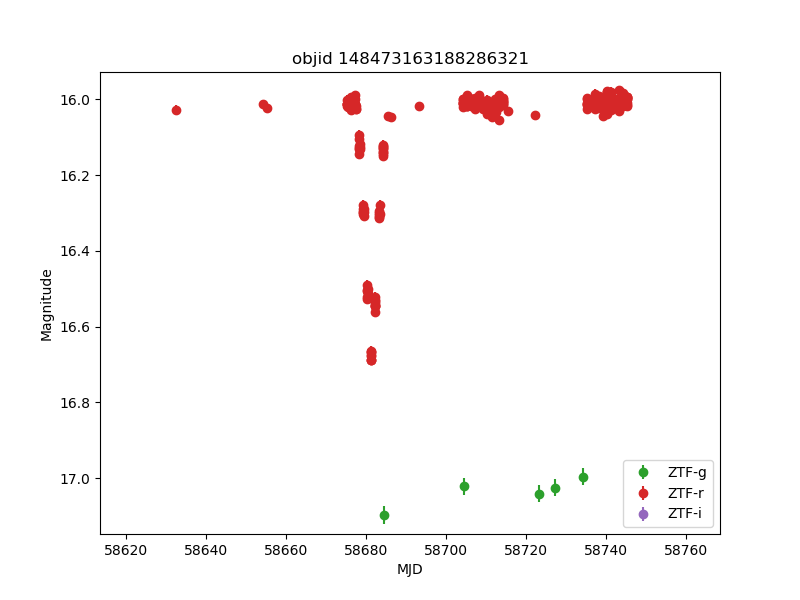

In [227]:
idx = 37
row = res_r[idx]
show_lightcurve(row)

<IPython.core.display.Javascript object>


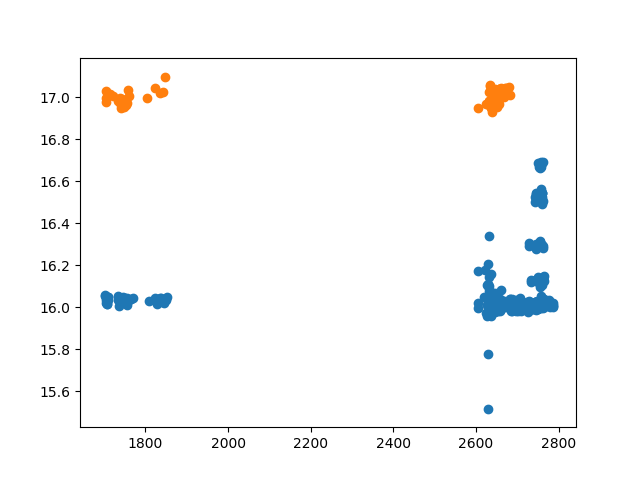

In [228]:
plt.figure()
plt.scatter(row['xpos_r'], row['mag_r'])
plt.scatter(row['xpos_g'], row['mag_g'])

## Weird artifacts - position glitches?

http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=280.941092+49.069733&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=
RA+Dec: 280.941092+49.069733
RA:     280.941092
Dec:    49.069733
ZTF-g: Score: 41.78, Max MJD: 58376.24
ZTF-r: Score: 15.18, Max MJD: 58354.32
ZTF-i: Score: 40.91, Max MJD: 58366.29


<IPython.core.display.Javascript object>


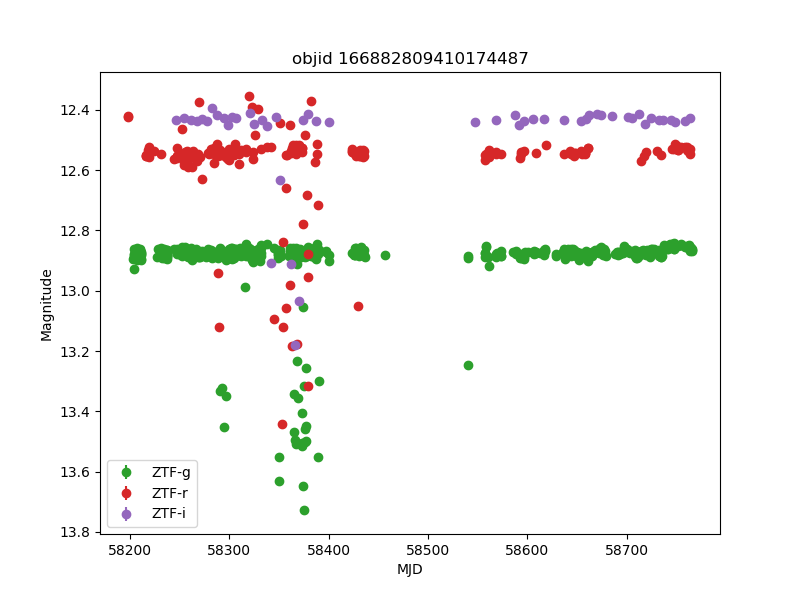

In [51]:
idx = 6

show_lightcurve(res_g[idx])

<IPython.core.display.Javascript object>


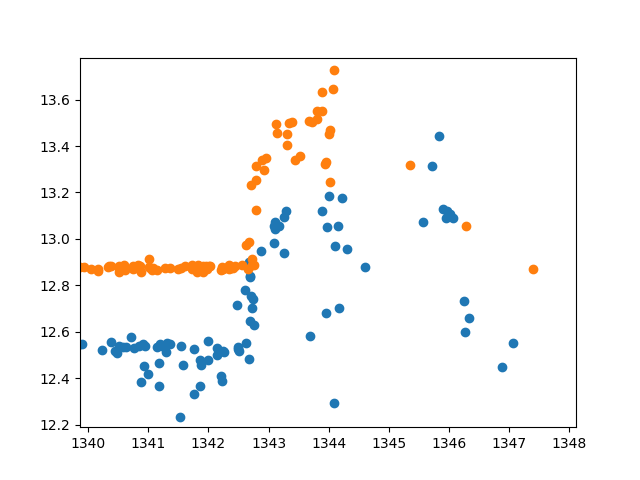

6


In [42]:
plt.figure()
print(idx)
plt.scatter(res_g[idx]['xpos_r'], res_g[idx]['mag_r'])
plt.scatter(res_g[idx]['xpos_g'], res_g[idx]['mag_g'])

<IPython.core.display.Javascript object>


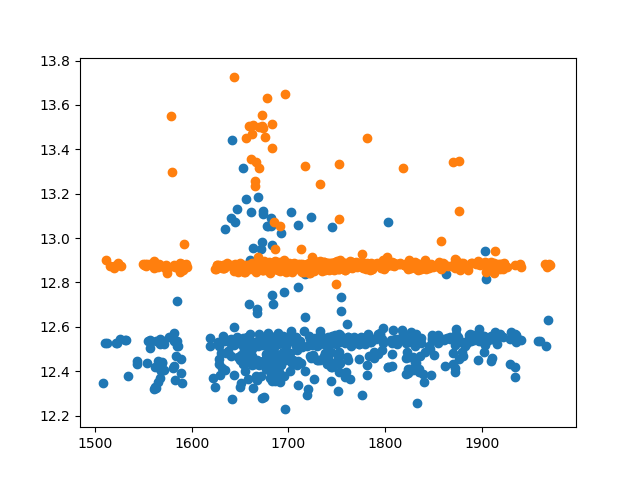

6


In [43]:
plt.figure()
print(idx)
plt.scatter(res_g[idx]['ypos_r'], res_g[idx]['mag_r'])
plt.scatter(res_g[idx]['ypos_g'], res_g[idx]['mag_g'])

<IPython.core.display.Javascript object>


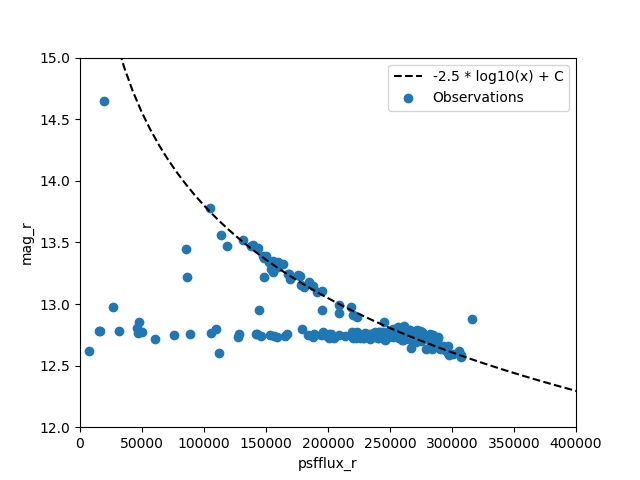

/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


In [352]:
plt.figure()
plt.scatter(res_g[idx]['psfflux_r'], res_g[idx]['mag_r'], label='Observations')
plt.xlabel('psfflux_r')
plt.ylabel('mag_r')
x = np.linspace(0, 700000, 100)
plt.plot(x, -2.5*np.log10(x) + 26.3, c='k', ls='--', label='-2.5 * log10(x) + C')
plt.xlim(0, 400000)
plt.ylim(12, 15)

plt.legend()

<IPython.core.display.Javascript object>


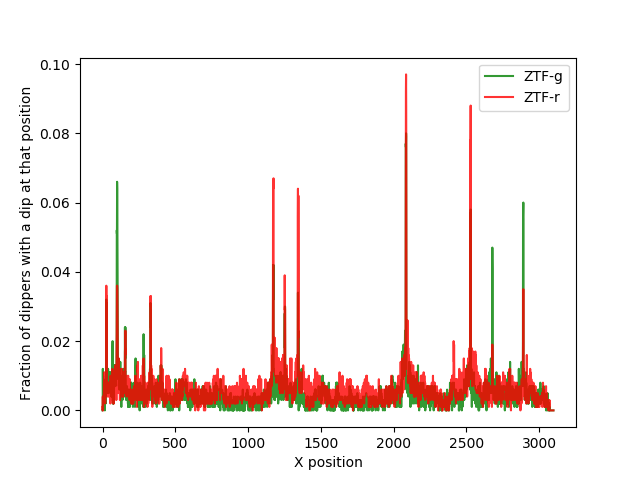

<IPython.core.display.Javascript object>


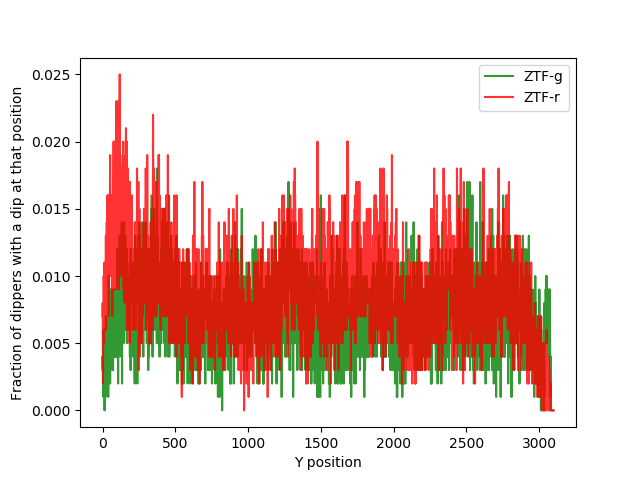

In [71]:
for coordinate in ['x', 'y']:
    plt.figure()

    for band in ['g', 'r']:
        bad_counts = np.zeros(3100)

        if band == 'g':
            res = res_g
        else:
            res = res_r

        for row in res:
            vals = row[f'mag_{band}']
            nmad = 1.48 * np.median(np.abs(vals - np.median(vals)))
            diffs = np.abs(vals - np.median(vals)) / nmad

            cut = diffs > 3

            row_mask = np.zeros(3100)

            for pos in np.array(row[f'{coordinate}pos_{band}'])[cut]:
                row_mask[int(pos)] = 1

            bad_counts += row_mask

        plt.plot(bad_counts / len(res), alpha=0.8, c=band, label=f'ZTF-{band}')

    plt.xlabel(f'{coordinate.upper()} position')
    plt.ylabel('Fraction of dippers with a dip at that position')
    plt.legend()

In [85]:
bad_ranges = [
    [24, 31],
    [95, 106],
    [328, 333],
    [1169, 1177],
    [1249, 1257],
    [1339, 1349],
    [2076, 2100],
    [2521, 2537],
    [2676, 2682],
    [2888, 2895],
]

coordinate = 'x'

print("min x")

for min_range, max_range in bad_ranges:
    for band in ['g', 'r']:
        if band == 'g':
            res = res_g
        else:
            res = res_r
            
        max_count = 0
        max_row = None

        for row in res:
            vals = row[f'mag_{band}']
            nmad = 1.48 * np.median(np.abs(vals - np.median(vals)))
            diffs = np.abs(vals - np.median(vals)) / nmad

            cut = diffs > 3
            
            pos = np.array(row[f'{coordinate}pos_{band}'])[cut]
            
            count = np.sum((pos > min_range) & (pos < max_range))
            
            if count > max_count:
                max_row = row
                max_count = count

    print(f'{min_range:4d} {max_range:4d} {max_row["ra"]:.5f} {max_row["dec"]:.5f}')


  24   31 329.28205 46.68537
  95  106 331.87282 53.83404
 328  333 327.64785 50.37026
1169 1177 337.79518 56.04885
1249 1257 324.14884 46.52748
1339 1349 296.68662 34.41915
2076 2100 325.43789 49.34005
2521 2537 319.51116 50.24050
2676 2682 276.16895 41.71979
2888 2895 345.96508 53.90185


## Weird artifacts - bad magerr?

http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=303.767916+46.455541&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=
RA+Dec: 303.767916+46.455541
RA:     303.767916
Dec:    46.455541
ZTF-g: Score: 37.82, Max MJD: 58255.44
ZTF-r: Score: 53.62, Max MJD: 58255.47
ZTF-i: Score: -1.00, Max MJD: nan


<IPython.core.display.Javascript object>


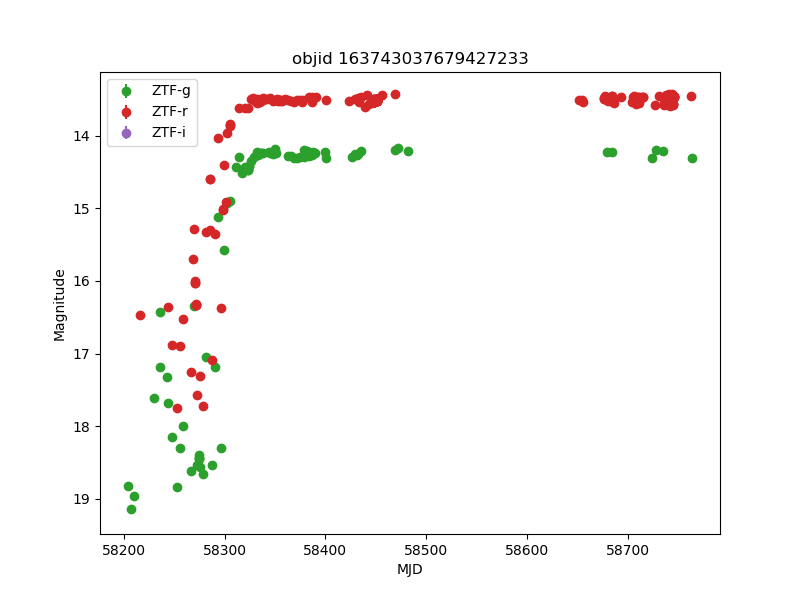

In [135]:
show_lightcurve(res_r[2])

In [388]:
print('catflags magerr')

for c, e in zip(res_r[2]['catflags_r'], res_r[2]['magerr_r']):
    if c == 0 and e == 0:
        label = '<----'
    else:
        label = ''
    print(f'{c:6d}   {e:5f} {label}')

catflags magerr
     0   0.104313 
     0   0.107360 
-32768   0.000000 
     0   0.114456 
     0   0.109260 
     0   0.124042 
     0   0.092218 
-32768   0.000000 
     0   0.102249 
     0   0.097702 
-32768   0.000000 
     0   0.100786 
-32768   0.000000 
     0   0.087615 
-32768   0.000000 
     0   0.096537 
-32768   0.000000 
     0   0.000000 <----
-32768   0.000000 
-32768   0.101492 
-32768   0.000000 
-32768   0.103396 


# Joining

In [12]:
gaia = catalog.load('gaia_dr2_1am_dup')

In [13]:
wtf_df = wtf.crossmatch(gaia.select('ra', 'dec', 'zone', 'dup', 'parallax', 'parallax_over_error', 'phot_g_mean_mag',
                                'bp_rp')).toPandas()

In [17]:
new_scores = []
for idx, row in tqdm.tqdm(wtf_df.iterrows()):
    new_scores.append(detect_dippers_row(row))

wtf_df['new_score'] = new_scores

41942it [00:56, 748.45it/s]


/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


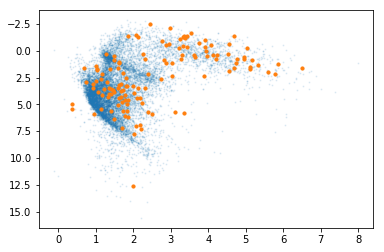

In [36]:
plt.figure()
abs_mag = wtf_df['phot_g_mean_mag'] - 5 * np.log10(1000 / wtf_df['parallax']) + 5

cut = (wtf_df['parallax_over_error'] > 5)
plt.scatter(wtf_df['bp_rp'][cut], abs_mag[cut], s=1, alpha=0.1)

cut = (wtf_df['parallax_over_error'] > 5) & (wtf_df['new_score'] > 2.5)
plt.scatter(wtf_df['bp_rp'][cut], abs_mag[cut], s=10)


plt.gca().invert_yaxis()

In [40]:
def print_links(row):
    print("http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%.6f%+.6f&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=" % (row['ra'], row['dec']))
    print("RA+Dec: %.6f%+.6f" % (row['ra'], row['dec']))
    print("RA:     %.6f" % row['ra'])
    print("Dec:    %.6f" % row['dec'])

def show_lightcurve(idx):
    row = wtf_df.iloc[idx]  
    #print_links(row)    
    plot_lightcurve(row)
    plt.title(idx)

    print("Score:  %.3f" % detect_dippers_row(row))

In [41]:
a = np.where(cut & (df['bp_rp'] > 0.5) & (df['bp_rp'] < 2) & (abs_mag < 1000) & (abs_mag > 5.))

Score:  2.566
Score:  2.795
Score:  2.650
Score:  2.909
Score:  2.530
Score:  2.687
Score:  2.845
Score:  2.584
Score:  2.648
Score:  3.264
Score:  3.082


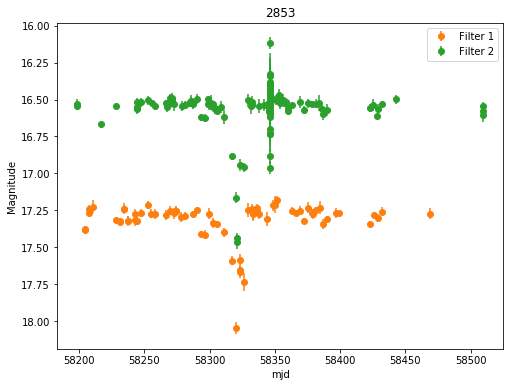

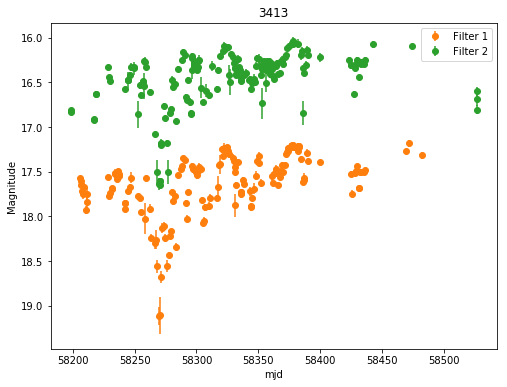

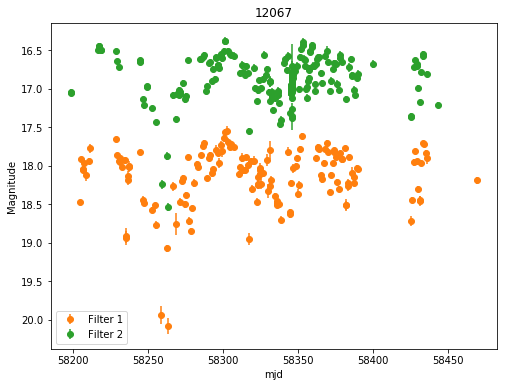

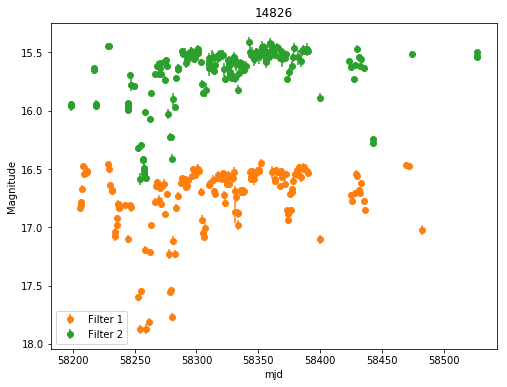

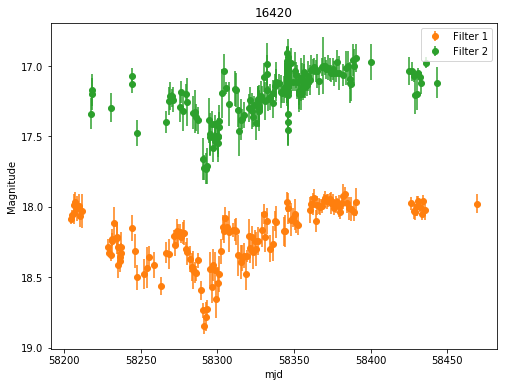

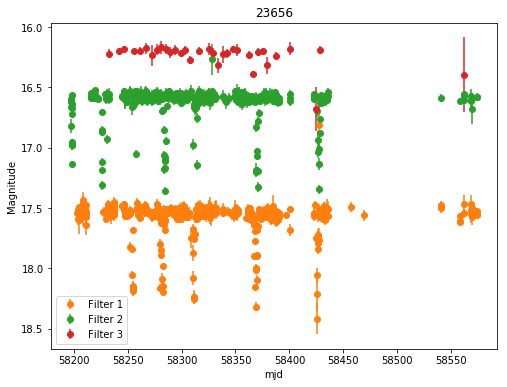

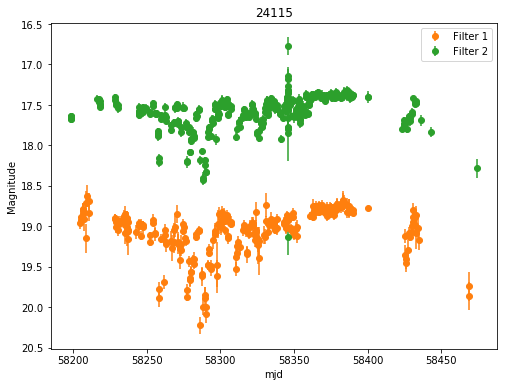

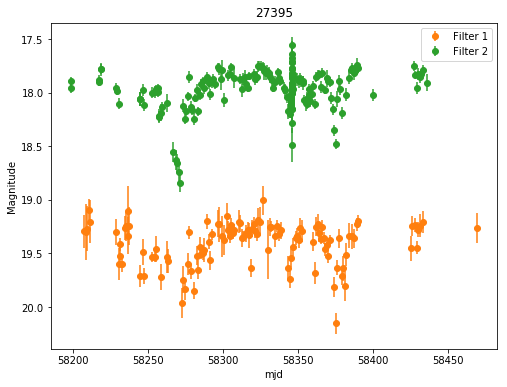

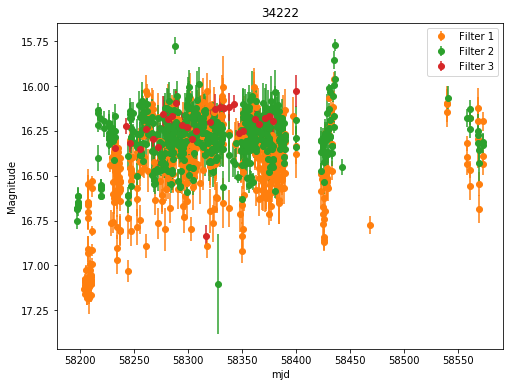

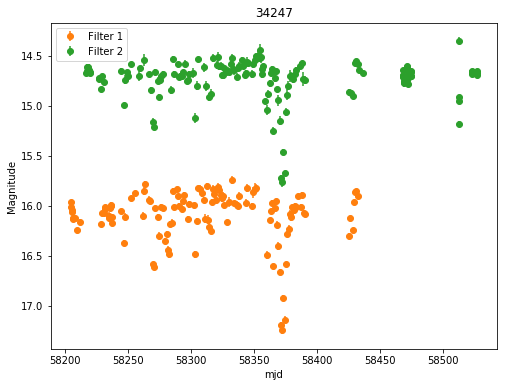

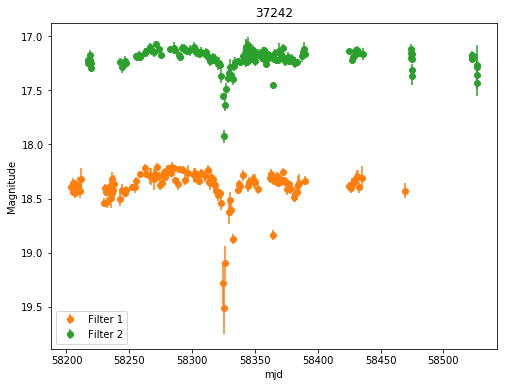

In [42]:
for i in a[0]:
    show_lightcurve(i)